In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
class self_attention(keras.layers.Layer):
    def __init__(self, units=512, dk=64, dv=64):
        super().__init__()
        self.units = units
        self.dk = dk
        self.dv = dv
        self.scale_factor = 1/(self.dk**(1/2))
        self.softmax = tf.keras.layers.Softmax(axis=-1)
        
    def build(self, input_shape):
        #W_query
        self.w_q = self.add_weight(shape=(self.units, self.dk),
                                   initializer="random_normal", 
                                   trainable=True)
        #W_key
        self.w_k = self.add_weight(shape=(self.units, self.dk),
                                   initializer="random_normal", 
                                   trainable=True)
        #W_value
        self.w_v = self.add_weight(shape=(self.units, self.dv),
                                   initializer="random_normal", 
                                   trainable=True)

    def call(self, inputs):
        query = tf.matmul(inputs, self.w_q)
        key = tf.matmul(inputs, self.w_k)
        value = tf.matmul(inputs, self.w_v)
        
        # Q x K_T
        score = tf.matmul(query, key, transpose_b=True)
        # Summation: [q1k1+q1k2+q1k3+.., q2k1+q2k2+q2k3+.., ..]
        score = tf.reduce_sum(score, axis=2, keepdims=True)
        # Scaling the score with 1/sqrt(dk)
        score = score*self.scale_factor
        # Using softmax
        normalized_score = self.softmax(score)
        
        z = normalized_score*value
        
        return z

In [3]:
class multi_head_attention(tf.keras.layers.Layer):
    def __init__(self, n_head=8, units=512):
        super().__init__()
        self.n_head = n_head
        self.units = units # <- d_model
        self.dk = self.units//self.n_head
        self.dv = self.dk
        self.attention = self_attention(units=self.units, dk=self.dk, dv=self.dv)
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.W = self.add_weight(shape=(self.n_head*self.dv, self.units),
                                   initializer="random_normal", 
                                   trainable=True)
        
    def call(self, inputs):
        head_list = []
        for _ in range(self.n_head):
            head = self.attention(inputs)
            head_list.append(head)
            
        concat_heads = self.concat(head_list)
        z = tf.matmul(concat_heads, self.W)
        
        return z

In [4]:
class add_normalize(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.add = tf.keras.layers.Add()
        self.normalize = tf.keras.layers.BatchNormalization()#tf.keras.layers.LayerNormalization()
        
    def call(self, inputs):
        # Addition
        x1 = self.add([inputs[0], inputs[1]])
        # Normalization
        x2 = self.normalize(x1)
        
        return x2

In [5]:
class encoder(tf.keras.layers.Layer):
    def __init__(self, units=512, n_head=8):
        super().__init__()
        self.units = units
        self.n_head = n_head
        self.self_attention = multi_head_attention(self.n_head, self.units)
        self.add_normalize = add_normalize()
        self.dense = tf.keras.layers.Dense(self.units, 
                                           activation='relu',
                                           kernel_initializer='glorot_uniform')
        
    def call(self, inputs):
        # Self-Attention
        x1 = self.self_attention(inputs)
        
        # Add & Normalize
        x2 = self.add_normalize([inputs, x1])
        
        # Feed Forward
        x3 = self.dense(x2)
        
        # Add & Normalize
        x4 = self.add_normalize([x2, x3])
        
        return x4

In [6]:
class bert_base(tf.keras.layers.Layer):
    def __init__(self, L=12, H=768, A=12):
        super().__init__()
        # L -> Number of transformer blocks (encoders)
        # H -> Hidden vector size
        # A -> Number of Attention Heads
        self.L = L
        self.H = H
        self.A = A
        
        # transformer block (encoder)
        self.encoder_block = encoder(units=self.H, n_head=self.A)
        
    def call(self, inputs):
        x = inputs
        for _ in range(self.L):
            x = self.encoder_block(x)
            
        return x

In [7]:
inputs = keras.Input(shape=(10,768,))
outputs = bert_base(L=12, H=768, A=12)(inputs)

model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 768)]         0         
_________________________________________________________________
bert_base (bert_base)        (None, 10, 768)           1330944   
Total params: 1,330,944
Trainable params: 1,329,408
Non-trainable params: 1,536
_________________________________________________________________


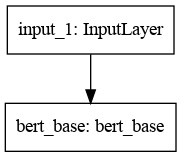

In [9]:
keras.utils.plot_model(model, "Bert_Base.png")

In [10]:
class encoder_decoder_attention(tf.keras.layers.Layer):
    def __init__(self, units=512, dk=64, dv=64):
        super().__init__()
        self.units = units
        self.dk = dk
        self.dv = dv
        self.scale_factor = 1/(self.dk**(1/2))
        self.softmax = tf.keras.layers.Softmax(axis=-1)
        
    def build(self, input_shape):
        encoder_out_shape, decoder_in_shape = input_shape[0], input_shape[1]
        
        # W_query
        self.w_q = self.add_weight(shape=(encoder_out_shape[2], self.dk),
                                   initializer="random_normal", 
                                   trainable=True)
        # W_key
        self.w_k = self.add_weight(shape=(encoder_out_shape[2], self.dk),
                                   initializer="random_normal", 
                                   trainable=True)
        # W_value
        self.w_v = self.add_weight(shape=(decoder_in_shape[2], self.dv),
                                   initializer="random_normal", 
                                   trainable=True)

    def call(self, inputs):
        encoder_output, decoder_input = inputs[0], inputs[1]
        
        query = tf.matmul(encoder_output, self.w_q)
        key = tf.matmul(encoder_output, self.w_k)
        value = tf.matmul(decoder_input, self.w_v)
        
        # Q x K_T
        score = tf.matmul(query, key, transpose_b=True)
        # Summation: [q1k1+q1k2+q1k3+.., q2k1+q2k2+q2k3+.., ..]
        score = tf.reduce_sum(score, axis=2, keepdims=True)
        # Scaling the score with 1/sqrt(dk)
        score = score*self.scale_factor
        # Using softmax
        normalized_score = self.softmax(score)
        
        z = normalized_score*value
        
        return z

In [11]:
class multi_e_d_attention(tf.keras.layers.Layer):
    def __init__(self, n_head=8, units=512):
        super().__init__()
        self.n_head = n_head
        self.units = units # <- d_model
        self.dk = self.units//self.n_head
        self.dv = self.dk
        self.attention = encoder_decoder_attention(units=self.units, dk=self.dk, dv=self.dv)
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.W = self.add_weight(shape=(self.n_head*self.dv, self.units),
                                   initializer="random_normal", 
                                   trainable=True)
        
    def call(self, inputs):
        head_list = []
        for _ in range(self.n_head):
            head = self.attention(inputs)
            head_list.append(head)
            
        concat_heads = self.concat(head_list)
        z = tf.matmul(concat_heads, self.W)
        
        return z

In [12]:
class decoder(tf.keras.layers.Layer):
    def __init__(self, units=512, n_head=8):
        super().__init__()
        self.units = units
        self.n_head = n_head
        self.dk = self.units//self.n_head
        self.self_attention = multi_head_attention(self.n_head, self.units)
        self.add_normalize = add_normalize()
        self.encoder_decoder_attention = multi_e_d_attention(n_head=self.n_head,
                                                             units=self.units)
        self.dense = tf.keras.layers.Dense(self.units, 
                                           activation='relu',
                                           kernel_initializer='glorot_uniform')
        
    def call(self, inputs):
        # Encoder's output & Decoder's input
        encoder_output, decoder_input = inputs[0], inputs[1]
        
        # Self-Attention
        x1 = self.self_attention(decoder_input)
        
        # Add & Normalize
        x2 = self.add_normalize([decoder_input, x1])
        
        # Encoder-Decoder Attenion
        x3 = self.encoder_decoder_attention([encoder_output, x2])
        
        # Add & Normalize
        x4 = self.add_normalize([x2, x3])
        
        # Feed Forward
        x5 = self.dense(x4)
        
        # Add & Normalize
        x6 = self.add_normalize([x4, x5])
        
        return x6

In [13]:
class encoder_Nx(tf.keras.layers.Layer):
    def __init__(self, N=6, units=512, n_head=8):
        super().__init__()
        self.N = N
        self.units = units
        self.n_head = n_head
        self.encoder_block = encoder(units=self.units, n_head=self.n_head)
    
    def call(self, inputs):
        x = inputs
        for _ in range(self.N):
            x = self.encoder_block(x)
            
        return x

In [14]:
class decoder_Nx(tf.keras.layers.Layer):
    def __init__(self, N=6, units=512, n_head=8):
        super().__init__()
        self.N = N
        self.units = units
        self.n_head = n_head
        self.decoder_block = decoder(units=self.units, n_head=self.n_head)
        
    def call(self, inputs):
        # Encoder's output & Decoder's input
        encoder_output, x = inputs[0], inputs[1]
        
        for _ in range(self.N):
            x = self.decoder_block([encoder_output, x])
        
        return x

In [15]:
class transformer(tf.keras.layers.Layer):
    def __init__(self, N=6, units=512, n_head=8, vocab_size=1024):
        super().__init__()
        self.N = N
        self.units = units
        self.n_head = n_head
        self.vocab_size = vocab_size
        self.encoder_Nx = encoder_Nx(N=self.N, units=self.units, n_head=self.n_head)
        self.decoder_Nx = decoder_Nx(N=self.N, units=self.units, n_head=self.n_head)
        self.dense = tf.keras.layers.Dense(self.vocab_size, 
                                           activation=None,
                                           kernel_initializer='glorot_uniform')
        self.softmax = tf.keras.layers.Softmax(axis=-1)
        
    def call(self, inputs):
        # Encoder's input, Decoder's input
        encoder_input, decoder_input = inputs[0], inputs[1]
        
        x1 = self.encoder_Nx(encoder_input)
        x2 = self.decoder_Nx([x1, decoder_input])
        x3 = self.dense(x2)
        x4 = self.softmax(x3)
        
        return x4

In [16]:
encoder_inputs = keras.Input(shape=(10,512,), name='encoder_inputs')
decoder_inputs = keras.Input(shape=(10,512,), name='decoder_inputs')
outputs= transformer(N=6,units=512,n_head=8,vocab_size=1024)([encoder_inputs,decoder_inputs])

model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 10, 512)]    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 10, 512)]    0                                            
__________________________________________________________________________________________________
transformer (transformer)       (None, 10, 1024)     2136064     encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
Total params: 2,136,064
Trainable params: 2,134,016
Non-trainable params: 2,048
__________________________________________________________________________________________________


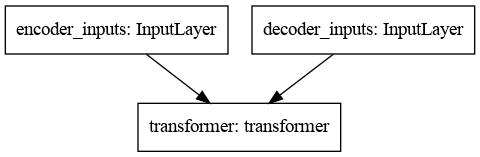

In [18]:
keras.utils.plot_model(model, "Transformer.png")